In [0]:
import torch
import math
import numpy as np
import torch.nn as nn
import scipy.stats as st
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import torchvision.transforms as transforms
from sklearn.mixture import GaussianMixture

#Q-5
### Hyper parameter

In [0]:
batch_size = 256
epochs=12000
d_step=20

## Function $f(x)$ to generate true samples:
\begin{equation}
    f(x) = 0.4\mathcal{N}(0,4)+0.3\mathcal{N}(-6,4)+0.3\mathcal{N}(6,4)
\end{equation}
where $\mathcal{N}(\mu,\sigma^2)$ is the Gaussian distrubution with mean $\mu$ and variance $\sigma^2$.

In [0]:
def gen_data(size=10000,dim=1):
  return 0.4*np.random.normal(0, 4, (size,dim)) + 0.3*np.random.normal(6, 4,(size,dim)) + 0.3*np.random.normal(-6, 4, (size,dim))

def sample_noise(size):
    return np.linspace(-5.0, 5.0, size) + np.random.random(size) * 0.01

## GAN 
The GAN algoritjm involves the interplay of two adversaries namely generator and discriminator. In this the generator tries to generate points such that they closely resemble to the point in the original distribution. While a discriminator tries to judge the truthfull ness of the points(if they are generated from original distribution or not).  We train the discriminator  just like  the way we would train any network using both true and false (generated) samples to learn. But for generator we feed the sample generated, through the disciminator to spot the fake and backpropagate the error through the discriminator and the generator.

## Generator Architecture
- I have designed the Generatore to model the above function $f(x)$. Given random samples as input, it is expected to output samples very close to $f(x)$,.
- It contained three fully connected network with the activation of Relu.

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.d1 = nn.Linear(1,10)
    self.a1 = nn.ReLU()
    self.d2 = nn.Linear(10,10)
    self.a2 = nn.ReLU()
    self.d3 = nn.Linear(10,1)

  def forward(self, x):
    x =self.a1(self.d1(x))
    x =self.a2(self.d2(x))
    x=self.d3(x)
    return x

## Discriminator Architecture
- The Discriminator is designed in such a way to check the validity of samples,ie, the samples are generated from a true source ( $f(x)$ disrtibution) or from some other source (generator).
-  It contained three fully connected network with the activation of Tanh and relu. 

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.d1 = nn.Linear(1,10)
    self.a1 = nn.Tanh()
    self.d2 = nn.Linear(10,10)
    self.a2 = nn.Tanh()
    self.d3 = nn.Linear(10,1)
    self.a3 = nn.Sigmoid()

  def forward(self, x):
    x =self.a1(self.d1(x))
    x =self.a2(self.d2(x))
    x =self.a3(self.d3(x))
    return x


In [0]:
gen=Generator()
print(gen)
dis=Discriminator()
print(dis)

Generator(
  (d1): Linear(in_features=1, out_features=10, bias=True)
  (a1): ReLU()
  (d2): Linear(in_features=10, out_features=10, bias=True)
  (a2): ReLU()
  (d3): Linear(in_features=10, out_features=1, bias=True)
)
Discriminator(
  (d1): Linear(in_features=1, out_features=10, bias=True)
  (a1): Tanh()
  (d2): Linear(in_features=10, out_features=10, bias=True)
  (a2): Tanh()
  (d3): Linear(in_features=10, out_features=1, bias=True)
  (a3): Sigmoid()
)


In [0]:
d_optimizer = torch.optim.SGD(dis.parameters(), lr=0.1, momentum=0.6)
g_optimizer = torch.optim.SGD(gen.parameters(), lr=0.01, momentum=0.6)

## Loss

- Loss for dicriminator is given by:
\begin{equation}
max_D V(D,G) = -0.5* \mathbb{E}_{x \sim f(x)}\big[logD(x) + log(1-D(G(z)))\big]
\end{equation}
- Loss for generator is given by:
\begin{equation}
max_G V(D,G) = -\mathbb{E}_{x \sim f(x)}\big[logD(G(z))\big]
\end{equation}
where $D(x)$ and $G(x)$ are discriminator and generator networks respectively.


In [0]:
def gen_criterion(x):
    return  -torch.mean(torch.log(x))

def dis_criterion(x,y):
    return -0.5*torch.mean(torch.log(x) + torch.log(1 - y))

## Training our GAN Network.
- We train for 20000 epochs.
- We expect the loss of Generator and Discriminator will find a mid way  and at this point it will aslo become costant.

In [0]:
gen_loss_hist=np.zeros(epochs)
dis_loss_hist=np.zeros(epochs)
for i in range(epochs):
  for j in range(d_step):
    dis.zero_grad()
    data_mini_batch= gen_data(batch_size)
    u = sample_noise(batch_size).reshape(batch_size,1)
    u_t =torch.tensor(u).float()
    data_mini_batch_t =torch.tensor(data_mini_batch).float()
    
    fake_data = gen(u_t)
    fake_data_label = dis(fake_data)
    
    true_data_label = dis(data_mini_batch_t)
    
    loss = dis_criterion(true_data_label, fake_data_label)
    loss.backward()
    d_optimizer.step()
    dis_loss_hist[i]=loss.item()

  gen.zero_grad()
  u = sample_noise(batch_size).reshape(batch_size,1)
  u_t =torch.tensor(u).float()

  gen_copy = gen(u_t)
  gen_copy_label = dis(gen_copy)
  loss = gen_criterion(gen_copy_label)
  loss.backward()
  g_optimizer.step()
  gen_loss_hist[i]=loss.item()
  if i % 10 == 0:
    for p in g_optimizer.param_groups:
        p['lr'] *= 0.999
    for p in d_optimizer.param_groups:
        p['lr'] *= 0.999


## Plot of discriminator/generator epoch versus error curve.
- We see that as end of training, both the curves meet and also becomes almost constant. It now generator is not able to differentiate fake and true points.

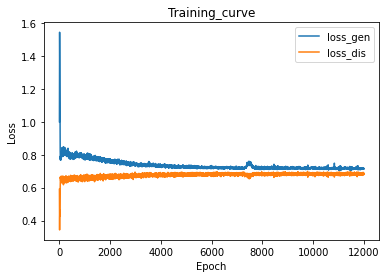

In [0]:
plt.plot(range(epochs),gen_loss_hist, label='loss_gen')
plt.plot(range(epochs),dis_loss_hist, label='loss_dis')
plt.title('Training_curve')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Tesing

In [0]:
Test=3000
Real_points=gen_data(Test).reshape(-1)
u_test = sample_noise(Test).reshape(Test,1)
u_test_t =torch.tensor(u_test).float()
Fake_test= gen(u_test_t)
Fake_points=Fake_test.detach().numpy().reshape(-1)


### Histogram of points fake points generated by Generator compared with real points.
- We observe in the histogram generated by fake points is almost similar to real one.

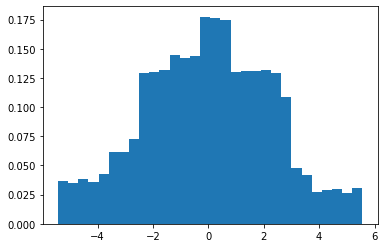

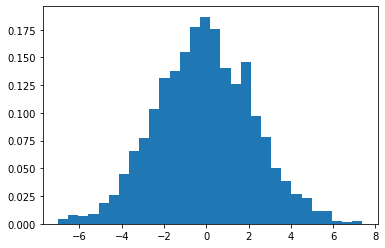

In [0]:
plt.hist(Fake_points[:], bins=30, density = True)
plt.show()
plt.hist(Real_points[:], bins=30, density = True)
plt.show()


- Fitting a GMM (Gaussian Mixture Model) to the samples using EM algorithm.


In [0]:
GMM = GaussianMixture(n_components=3).fit(Fake_points[:].reshape(-1,1))

- Checking for the convergence of GMM

In [0]:
print('Converged:',GMM.converged_) # Check if the model has converged
means = GMM.means_ 
cov=GMM.covariances_
weights = GMM.weights_

Converged: True


### Mean

In [0]:
print("Means:")
print(means)

Means:
[[ 2.34384897]
 [-2.66408054]
 [-0.14970875]]


### Covariance 

In [0]:
print("Covariance:")
print(cov)

Covariance:
[[[1.96810229]]

 [[1.89176525]]

 [[1.33953062]]]


### Weights

In [0]:
print("Weights:")
print(weights)

Weights:
[0.32436141 0.26834681 0.40729178]


### KL-Divergence of the Between the 2 distributions.

In [0]:
log_gan = GMM.score_samples(Fake_points.reshape(-1,1))
log_x = GMM.score_samples(Real_points.reshape(-1,1))
print(log_gan.mean() - log_x.mean())

-0.010996733169122752
